# Gray-Scott Model

In [1]:
import numpy as np

In [2]:
%config InlineBackend.figure_format = 'retina'

The reaction-diffusion system described here involves two generic chemical species U and V, whose concentration at a given point in space is referred to by variables u and v. As the term implies, they react with each other, and they diffuse through the medium. Therefore the concentration of U and V at any given location changes with time and can differ from that at other locations.

The overall behavior of the system is described by the following formula, two equations which describe three sources of increase and decrease for each of the two chemicals:


$$
\begin{array}{l}
\displaystyle \frac{\partial u}{\partial t} = D_u \Delta u - uv^2 + F(1-u) \\
\displaystyle \frac{\partial v}{\partial t} = D_v \Delta v + uv^2 - (F+k)v
\end{array}
$$

The laplacian is computed with the following numerical scheme

$$
\Delta u_{i,j} \approx u_{i,j-1} + u_{i-1,j} -4u_{i,j} + u_{i+1, j} + u_{i, j+1}
$$

The classic Euler scheme is used to integrate the time derivative.

## Initialization

$u$ is $1$ everywhere et $v$ is $0$ in the domain except in a square zone where $v = 0.25$ and $ u = 0.5$. This square located in the center of the domain is  $[0, 1]\times[0,1]$ with a size of $0.2$.


In [3]:
def init(n):
 
    u = np.ones((n+2,n+2))
    v = np.zeros((n+2,n+2))
    
    x, y = np.meshgrid(np.linspace(0, 1, n+2), np.linspace(0, 1, n+2))

    mask = (0.4<x) & (x<0.6) & (0.4<y) & (y<0.6)
    
    u[mask] = 0.50
    v[mask] = 0.25
        
    return u, v

## Boundary conditions

We assume that the domain is periodic.


In [4]:
def periodic_bc(u):
    u[0, :] = u[-2, :]
    u[-1, :] = u[1, :]
    u[:, 0] = u[:, -2]
    u[:, -1] = u[:, 1]

## Laplacian

In [5]:
def laplacian(u):
    """
    second order finite differences
    """
    return (                  u[ :-2, 1:-1] +
             u[1:-1, :-2] - 4*u[1:-1, 1:-1] + u[1:-1, 2:] +
                          +   u[2:  , 1:-1] )

## Gray-Scott model

In [6]:
def grayscott(U, V, Du, Dv, F, k):
    
    u, v = U[1:-1,1:-1], V[1:-1,1:-1]

    Lu = laplacian(U)
    Lv = laplacian(V)

    uvv = u*v*v
    u += Du*Lu - uvv + F*(1 - u)
    v += Dv*Lv + uvv - (F + k)*v

    periodic_bc(U)
    periodic_bc(V)

## Visualization

Nous utiliserons les données suivantes.

In [7]:
Du, Dv = .1, .05
F, k = 0.0545, 0.062

In [8]:
%%time
from tqdm import tqdm_notebook as tqdm
from PIL import Image
U, V = init(300)

def create_image():
    global U, V
    for t in range(40):
        grayscott(U, V, Du, Dv, F, k)
    V_scaled = np.uint8(255*(V-V.min()) / (V.max()-V.min()))
    return V_scaled

def create_frames(n):

    return [create_image() for i in tqdm(range(n))]
    
frames = create_frames(500)

<timed exec>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



CPU times: user 48.5 s, sys: 24.5 s, total: 1min 12s
Wall time: 1min 12s


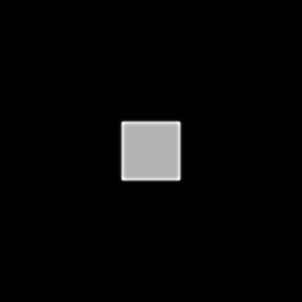

<function __main__.display_sequence(iframe)>

In [9]:
from ipywidgets import interact, IntSlider

def display_sequence(iframe):
    
    return Image.fromarray(frames[iframe])
    
interact(display_sequence, 
         iframe=IntSlider(min=0,
                          max=len(frames)-1,
                          step=1,
                          value=0, 
                          continuous_update=True))

In [10]:
import imageio
frames_scaled = [np.uint8(255 * frame) for frame in frames]
imageio.mimsave('movie.gif', frames_scaled, format='gif', fps=60)

In [11]:
from IPython.display import HTML
HTML('<img src="movie.gif">')

## References

- [Reaction-Diffusion by the Gray-Scott Model: Pearson's Parametrization](https://mrob.com/pub/comp/xmorphia/)

## Cython

[Program by Hyry](https://stackoverflow.com/questions/26823312/numba-or-cython-acceleration-in-reaction-diffusion-algorithm)

In [12]:
%load_ext cython
%env CC='gcc-8'

env: CC='gcc-8'


In [13]:
%%cython
#cython: boundscheck=False
#cython: wraparound=False
cimport cython
import numpy as np
cimport numpy as np

cpdef cython_grayscott(int counts, double Du, double Dv, double F, double k):
    cdef int n = 300
    cdef np.ndarray U = np.zeros((n+2,n+2), dtype=np.float_)
    cdef np.ndarray V = np.zeros((n+2,n+2), dtype=np.float_)
    cdef np.ndarray u = U[1:-1,1:-1]
    cdef np.ndarray v = V[1:-1,1:-1]

    cdef int r = 20
    u[:] = 1.0
    U[n/2-r:n/2+r,n/2-r:n/2+r] = 0.50
    V[n/2-r:n/2+r,n/2-r:n/2+r] = 0.25
    u += 0.15*np.random.random((n,n))
    v += 0.15*np.random.random((n,n))

    cdef np.ndarray Lu = np.zeros_like(u)
    cdef np.ndarray Lv = np.zeros_like(v)
    cdef int i, c, r1, c1, r2, c2
    cdef double uvv

    cdef double[:, ::1] bU = U
    cdef double[:, ::1] bV = V
    cdef double[:, ::1] bLu = Lu
    cdef double[:, ::1] bLv = Lv

    for i in range(counts):
        for r in range(n):
            r1 = r + 1
            r2 = r + 2
            for c in range(n):
                c1 = c + 1
                c2 = c + 2
                bLu[r,c] = bU[r1,c2] + bU[r1,c] + bU[r2,c1] + bU[r,c1] - 4*bU[r1,c1]
                bLv[r,c] = bV[r1,c2] + bV[r1,c] + bV[r2,c1] + bV[r,c1] - 4*bV[r1,c1]

        for r in range(n):
            r1 = r + 1
            for c in range(n):
                c1 = c + 1
                uvv = bU[r1,c1]*bV[r1,c1]*bV[r1,c1]
                bU[r1,c1] += Du*bLu[r,c] - uvv + F*(1 - bU[r1,c1])
                bV[r1,c1] += Dv*bLv[r,c] + uvv - (F + k)*bV[r1,c1]

    return V